<a href="https://colab.research.google.com/github/srvmishra/Language-Models/blob/main/Amazon_MultiLingual_Review_Summarization_with_google_mT5_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import markdown

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

import torch
import torch.nn as nn

from datasets import load_dataset, DatasetDict, concatenate_datasets
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

from huggingface_hub import notebook_login

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Load Dataset

The dataset from HuggingFace hub is defunct. It is no longer available. So, we load it from kaggle. This loads the dataset in 6 languages:
1. English
2. Spanish
3. French
4. German
5. Japanese
6. Chamorro

In [3]:
base_url = 'https://www.kaggle.com/api/v1/datasets/download/mexwell/amazon-reviews-multi'
datasets = {'train': base_url + '/train.csv',
            'validation': base_url + '/validation.csv',
            'test': base_url + '/test.csv'}
raw_datasets = load_dataset('csv', data_files=datasets)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 1200000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 30000
    })
})

In [4]:
samples = raw_datasets['train'].shuffle(42).select(range(5))
print(samples['language'])

['es', 'de', 'de', 'fr', 'es']


### Filter the Raw Data by Language

We select two languages for multi lingual summarization. Here we select English and German.

In [5]:
def language_filter(examples, lang='en'):
  return examples['language'] == lang

In [6]:
english_reviews_dataset = raw_datasets.filter(lambda x: language_filter(x, lang='en'))
english_reviews_dataset

Filter:   0%|          | 0/1200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [7]:
print('Train languages: ', english_reviews_dataset['train'].unique('language'))
print('Validation languages: ', english_reviews_dataset['validation'].unique('language'))
print('Test languages: ', english_reviews_dataset['test'].unique('language'))

Flattening the indices:   0%|          | 0/200000 [00:00<?, ? examples/s]

Train languages:  ['en']


Flattening the indices:   0%|          | 0/5000 [00:00<?, ? examples/s]

Validation languages:  ['en']


Flattening the indices:   0%|          | 0/5000 [00:00<?, ? examples/s]

Test languages:  ['en']


In [8]:
german_reviews_dataset = raw_datasets.filter(lambda x: language_filter(x, lang='de'))
german_reviews_dataset

Filter:   0%|          | 0/1200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [9]:
print('Train languages: ', german_reviews_dataset['train'].unique('language'))
print('Validation languages: ', german_reviews_dataset['validation'].unique('language'))
print('Test languages: ', german_reviews_dataset['test'].unique('language'))

Flattening the indices:   0%|          | 0/200000 [00:00<?, ? examples/s]

Train languages:  ['de']


Flattening the indices:   0%|          | 0/5000 [00:00<?, ? examples/s]

Validation languages:  ['de']


Flattening the indices:   0%|          | 0/5000 [00:00<?, ? examples/s]

Test languages:  ['de']


### Remove Unnecessary Column

The `Unnamed:0` column needs to be removed from the datasets.

In [10]:
english_reviews_dataset = english_reviews_dataset.remove_columns(['Unnamed: 0'])
german_reviews_dataset = german_reviews_dataset.remove_columns(['Unnamed: 0'])
print('English Data: ', english_reviews_dataset['train'].column_names)
print('German Data: ', german_reviews_dataset['train'].column_names)

English Data:  ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category']
German Data:  ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category']


### Filter by Product Category

First, we see the distribution of reviews by product category and select an appropriate product from both the datasets to construct the final multi-lingual summarization dataset. Here, we select the `pc` and `electronics` categories.

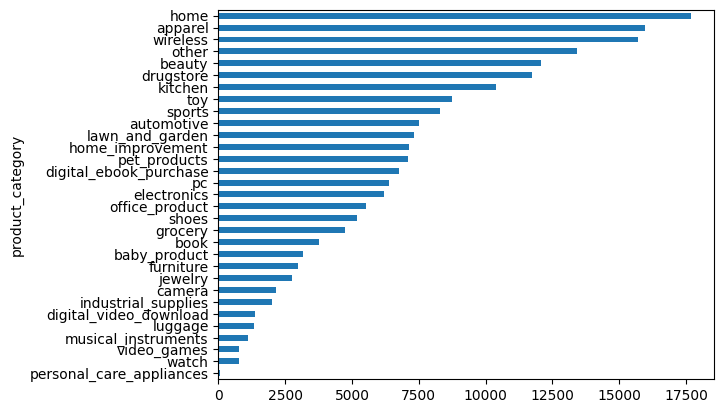

In [11]:
english_reviews_dataset.set_format('pandas')
english_reviews_df = english_reviews_dataset['train'][:]
english_reviews_df.value_counts('product_category', ascending=True).plot.barh()
english_reviews_dataset.reset_format()
plt.show()

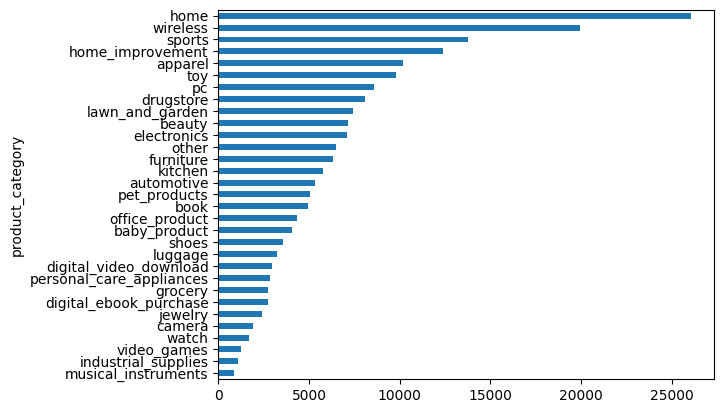

In [12]:
german_reviews_dataset.set_format('pandas')
spanish_reviews_df = german_reviews_dataset['train'][:]
spanish_reviews_df.value_counts('product_category', ascending=True).plot.barh()
german_reviews_dataset.reset_format()
plt.show()

In [13]:
def filter_by_category(examples):
  return examples['product_category'] == 'pc' or examples['product_category'] == 'electronics'

In [14]:
english_electronics_review_dataset = english_reviews_dataset.filter(filter_by_category)
english_electronics_review_dataset

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 12587
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 335
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 308
    })
})

In [15]:
german_electronics_review_dataset = german_reviews_dataset.filter(filter_by_category)
german_electronics_review_dataset

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 15691
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 394
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 392
    })
})

### Concatenate Datasets into a Multi Lingual Summarization Dataset

In [16]:
electronics_review_dataset = DatasetDict()

for split in english_electronics_review_dataset.keys():
  electronics_review_dataset[split] = concatenate_datasets([english_electronics_review_dataset[split],
                                                           german_electronics_review_dataset[split]])
  electronics_review_dataset[split].shuffle(42)

electronics_review_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 28278
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 729
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 700
    })
})

In [17]:
samples = electronics_review_dataset['train'].shuffle(42).select(range(5))
samples

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 5
})

In [18]:
for sample in samples:
  print('Review Title: ', sample['review_title'])
  print('Review Body: ', sample['review_body'])
  print('######################################')

Review Title:  Three Stars
Review Body:  Good speaker, easy to use, but it isn't as loud as I wanted.
######################################
Review Title:  Material
Review Body:  Würde nicht oft gebraucht. Material ist gut
######################################
Review Title:  Cheap construction
Review Body:  Touch part of several stylus pens came off and the stylus becomes non functional
######################################
Review Title:  Bis jetzt zufrieden
Review Body:  Ich habe die Boxen jetzt seit 2 Monaten, Ich bin sehr zufrieden. Ich spiele jetzt nicht sehr Laut, aber die Töne sind trotzdem schön deutlich. Das mit dem Bass finde Ich super, so etwas Ich nicht gewohnt, es fühlt sich schon ein wenig nach Kino an muss Ich sagen. 1 Punkt muss Ich abziehen da die Fernbedienung von der Nähe irgendwie nicht so gut funktioniert, das stört halt schon wenn man mit seinem Monitor spielt und deshalb auch sehr nah an den Boxen ist und dann seinen Arm nach hinten strecken muss um es Ein- oder

### Filter out Short Reviews

1. See the lengths of review titles as these will be used as summaries.
2. Filter out the reviews with very short titles.

Map:   0%|          | 0/28278 [00:00<?, ? examples/s]

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

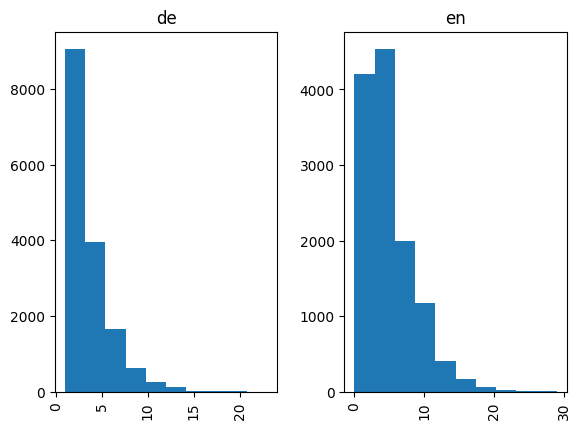

In [19]:
electronics_review_dataset = electronics_review_dataset.map(lambda x: {'title length': len(x['review_title'].split()) if x['review_title'] is not None else 0})
electronics_review_dataset.set_format('pandas')
electronics_review_df = electronics_review_dataset['train'][:]
electronics_review_df.hist('title length', by='language')
plt.show()
electronics_review_dataset.reset_format()

In [20]:
electronics_review_dataset = electronics_review_dataset.filter(lambda x: x['title length'] > 2)
electronics_review_dataset.set_format('pandas')
electronics_review_train_df = electronics_review_dataset['train'][:]
print('Train split by language after filtering: ', electronics_review_train_df.value_counts('language'))
electronics_review_valid_df = electronics_review_dataset['validation'][:]
print('Validation split by language after filtering: ', electronics_review_valid_df.value_counts('language'))
electronics_review_test_df = electronics_review_dataset['test'][:]
print('Test split by language after filtering: ', electronics_review_test_df.value_counts('language'))
electronics_review_dataset.reset_format()
electronics_review_dataset

Filter:   0%|          | 0/28278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/729 [00:00<?, ? examples/s]

Filter:   0%|          | 0/700 [00:00<?, ? examples/s]

Train split by language after filtering:  language
de    9256
en    8378
Name: count, dtype: int64
Validation split by language after filtering:  language
en    227
de    225
Name: count, dtype: int64
Test split by language after filtering:  language
de    222
en    200
Name: count, dtype: int64


DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 17634
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 452
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 422
    })
})

### Downsample the Dataset

Due to GPU space limitations, we downsample the train split into 8000 samples.

In [21]:
electronics_review_dataset_downsampled = DatasetDict()
electronics_review_dataset_downsampled['train'] = electronics_review_dataset['train'].shuffle(42).select(range(8000))
electronics_review_dataset_downsampled['validation'] = electronics_review_dataset['validation']
electronics_review_dataset_downsampled['test'] = electronics_review_dataset['test']
electronics_review_dataset_downsampled

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 452
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length'],
        num_rows: 422
    })
})

### Tokenize Dataset

First, we load the tokenizer for the `google/mt5-small` checkpoint and then tokenize the data. We set `max_length` to 512 for review body and 30 for review title fields. It is best to determine these values from by the distribution of lengths of these fields.

Why don't we include attention mask for the summary side? --> On the output side, causal attention is used because it is a sequence to sequence task. So, tokens are generated one by one till EOS is reached. Therefore, for all Seq2Seq tasks, the decoder inputs are the labels shifted by 1. The model only has access to past inputs, not the current ones. The decoder inputs are added by the Data Collator.

Input ids and attention masks are appended with the PAD token id while labels and decoder input ids are appended with -100 so that the trailing PAD tokens in the inputs are ignored by cross entropy loss during training. The decoder input ids have a PAD token at the beginning and then the labels follow in it.

In [22]:
model_ckpt = 'google/mt5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [23]:
input_max_length = 512
summary_max_length = 30

def tokenize_for_summarization(examples):
  model_inputs = tokenizer(examples['review_body'], max_length=input_max_length, truncation=True)
  labels = tokenizer(examples['review_title'], max_length=summary_max_length, truncation=True)
  model_inputs['labels'] = labels['input_ids']
  return model_inputs

In [24]:
electronics_review_dataset_tokenized = electronics_review_dataset_downsampled.map(tokenize_for_summarization, batched=True)
electronics_review_dataset_tokenized

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/452 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 452
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'title length', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 422
    })
})

In [25]:
electronics_review_dataset_tokenized = electronics_review_dataset_tokenized.remove_columns(electronics_review_dataset['train'].column_names)
electronics_review_dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 452
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 422
    })
})

### Define Data Collator for Summarization task

This is done by the `DataCollatorForSeq2Seq`. The data collator adds the `decoder_input_ids` fields to the datasets. The data collator does not know how to pad strings, so we remove the string columns before going for training and evaluation. We did it in the last step.

In [26]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

### Define Metrics for Measuing Summarization Performance

We use the ROGUE score. A confidence interval of scores is returned.

In [27]:
metrics = evaluate.load('rouge')

In [28]:
def compute_metrics(eval_preds):
  predictions, refs = eval_preds

  # remove special tokens -- ones with -100s
  # not doing this on the predictions results in overflow error during training
  predictions = np.where(predictions != -100, predictions, tokenizer.pad_token_id)
  summaries = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(refs != -100, refs, tokenizer.pad_token_id)
  labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # sentence tokenize and join each sentence by a new line
  predictions = ['\n'.join(sent_tokenize(text.strip())) for text in summaries]
  references = ['\n'.join(sent_tokenize(text.strip())) for text in labels]

  # compute metrics
  results = metrics.compute(predictions=predictions, references=references)

  # collect final results -- median values
  Results = {k: round(v * 100, 4) for k, v in results.items()}
  return Results

### 3 Sentence Summary Baseline with `nltk`



In [29]:
def three_sentence_summary(text):
  return "\n".join(sent_tokenize(text)[:3])

In [30]:
def evaluate_baseline(dataset, metrics):
  summaries = [three_sentence_summary(text) for text in dataset['review_body']]
  return metrics.compute(predictions=summaries, references=dataset['review_title'])

In [31]:
valid_scores = evaluate_baseline(electronics_review_dataset_downsampled['validation'], metrics)
names = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
valid_rouge_dict = dict((rn, round(valid_scores[rn] * 100, 2)) for rn in names)
print('Baseline performance on the validation dataset ....')
print(pd.DataFrame.from_dict(valid_rouge_dict, orient='index').to_markdown())

Baseline performance on the validation dataset ....
|           |     0 |
|:----------|------:|
| rouge1    | 16.38 |
| rouge2    |  8.81 |
| rougeL    | 15.15 |
| rougeLsum | 15.7  |


In [32]:
test_scores = evaluate_baseline(electronics_review_dataset_downsampled['test'], metrics)
test_rouge_dict = dict((rn, round(test_scores[rn] * 100, 2)) for rn in names)
print('Baseline performance on the test dataset ....')
print(pd.DataFrame.from_dict(test_rouge_dict, orient='index').to_markdown())

Baseline performance on the test dataset ....
|           |     0 |
|:----------|------:|
| rouge1    | 16.95 |
| rouge2    |  9.71 |
| rougeL    | 15.86 |
| rougeLsum | 16.18 |


### Finetune mt5-small Model for Multi Lingual Summarization

In [33]:
notebook_login()

In [34]:
batch_size = 16
logging_steps = len(electronics_review_dataset_tokenized['train'])//batch_size
model_name = f'srvmishra832/multilingual_review-amazon_dataset_electronics-en_de-{model_ckpt}'

training_arguments = Seq2SeqTrainingArguments(output_dir=model_name, evaluation_strategy='epoch',
                                              per_device_train_batch_size=batch_size,
                                              per_device_eval_batch_size=batch_size,
                                              num_train_epochs=10, learning_rate=5.6e-5,
                                              weight_decay=0.01, log_level='error',
                                              logging_steps=logging_steps,
                                              save_total_limit=5, disable_tqdm=False,
                                              push_to_hub=True, predict_with_generate=True)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer = Seq2SeqTrainer(model=model, args=training_arguments,
                         train_dataset=electronics_review_dataset_tokenized['train'],
                         eval_dataset=electronics_review_dataset_tokenized['validation'],
                         tokenizer=tokenizer, data_collator=data_collator,
                         compute_metrics=compute_metrics)

<ipython-input-35-96ca0706e19e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(model=model, args=training_arguments,


In [36]:
val_results = trainer.evaluate(electronics_review_dataset_tokenized['validation'])
val_dict = {k: round(v * 100, 4) for k, v in val_results.items()}
print(pd.DataFrame.from_dict(val_dict, orient='index').to_markdown())

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: srvmishra832 (srvmishra832-indian-institute-of-science-bangalore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


|                             |       0 |
|:----------------------------|--------:|
| eval_loss                   | 1949.95 |
| eval_model_preparation_time |    0.38 |
| eval_rouge1                 |   32.11 |
| eval_rouge2                 |    3.4  |
| eval_rougeL                 |   32.81 |
| eval_rougeLsum              |   32.52 |
| eval_runtime                |  794.28 |
| eval_samples_per_second     | 5690.7  |
| eval_steps_per_second       |  365.1  |


In [37]:
test_results = trainer.evaluate(electronics_review_dataset_tokenized['test'])
test_dict = {k: round(v * 100, 4) for k, v in test_results.items()}
print(pd.DataFrame.from_dict(test_dict, orient='index').to_markdown())

|                             |       0 |
|:----------------------------|--------:|
| eval_loss                   | 1964.55 |
| eval_model_preparation_time |    0.38 |
| eval_rouge1                 |   26.38 |
| eval_rouge2                 |    5.92 |
| eval_rougeL                 |   26.71 |
| eval_rougeLsum              |   26.44 |
| eval_runtime                |  745.55 |
| eval_samples_per_second     | 5660.2  |
| eval_steps_per_second       |  362.1  |


In [38]:
trainer.train()
trainer.push_to_hub(tags='summarization')

Epoch,Training Loss,Validation Loss,Model Preparation Time,Rouge1,Rouge2,Rougel,Rougelsum
1,9.088900,3.411723,0.003800,12.541000,5.102300,11.903900,11.874900
2,4.397700,3.189954,0.003800,15.342000,6.747000,14.922300,14.859800
3,3.959500,3.081701,0.003800,15.397600,6.206300,15.063500,15.069000
4,3.752500,3.055993,0.003800,15.799100,6.853600,15.465700,15.526300
5,3.619100,3.004775,0.003800,16.379100,7.367100,16.081700,16.059000
6,3.515500,2.977947,0.003800,16.231100,7.562900,15.749200,15.758000
7,3.449700,2.966302,0.003800,16.255400,8.146400,15.949900,15.915200
8,3.388900,2.943789,0.003800,16.576400,8.369800,16.322500,16.284800
9,3.365600,2.936459,0.003800,16.141600,8.026600,15.892100,15.891300
10,3.356200,2.936790,0.003800,16.195500,8.129200,15.921800,15.951600


events.out.tfevents.1743057325.fb6522921b78.695.0:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srvmishra832/mt5-small/commit/9eef8278bd80b654b0e703954033b2e199874e2e', commit_message='End of training', commit_description='', oid='9eef8278bd80b654b0e703954033b2e199874e2e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srvmishra832/mt5-small', endpoint='https://huggingface.co', repo_type='model', repo_id='srvmishra832/mt5-small'), pr_revision=None, pr_num=None)

In [40]:
val_results = trainer.evaluate(electronics_review_dataset_tokenized['validation'])
val_dict = {k: round(v * 100, 4) for k, v in val_results.items()}
print(pd.DataFrame.from_dict(val_dict, orient='index').to_markdown())

|                             |        0 |
|:----------------------------|---------:|
| eval_loss                   |  293.679 |
| eval_model_preparation_time |    0.38  |
| eval_rouge1                 | 1619.55  |
| eval_rouge2                 |  812.92  |
| eval_rougeL                 | 1592.18  |
| eval_rougeLsum              | 1595.16  |
| eval_runtime                | 2129.11  |
| eval_samples_per_second     | 2123     |
| eval_steps_per_second       |  136.2   |
| epoch                       | 1000     |


In [42]:
test_results = trainer.evaluate(electronics_review_dataset_tokenized['test'])
test_dict = {k: round(v * 100, 4) for k, v in test_results.items()}
print(pd.DataFrame.from_dict(test_dict, orient='index').to_markdown())

|                             |        0 |
|:----------------------------|---------:|
| eval_loss                   |  305.506 |
| eval_model_preparation_time |    0.38  |
| eval_rouge1                 | 1616.17  |
| eval_rouge2                 |  862.17  |
| eval_rougeL                 | 1597.6   |
| eval_rougeLsum              | 1595.14  |
| eval_runtime                | 1280.68  |
| eval_samples_per_second     | 3295.1   |
| eval_steps_per_second       |  210.8   |
| epoch                       | 1000     |


### Push the Amazon Reviews Dataset to HuggingFace Hub

In [43]:
raw_datasets = raw_datasets.remove_columns(['Unnamed: 0'])
raw_datasets.push_to_hub('srvmishra832/multilingual-amazon-reviews-6-languages')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1200 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/srvmishra832/multilingual-amazon-reviews-6-languages/commit/a32fcc83011415f63895dabaaf834b9eba8a5633', commit_message='Upload dataset', commit_description='', oid='a32fcc83011415f63895dabaaf834b9eba8a5633', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/srvmishra832/multilingual-amazon-reviews-6-languages', endpoint='https://huggingface.co', repo_type='dataset', repo_id='srvmishra832/multilingual-amazon-reviews-6-languages'), pr_revision=None, pr_num=None)

More tasks:

1. For the same datasets, use T5 and mBART and compare performance.

2. What are the maximum and minimum values that BLEU and ROUGE metrics can take?